<a href="https://colab.research.google.com/github/CoolCodeMan/intro2LT/blob/lauri/pytorch-embed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# **Links**

* https://github.com/CoolCodeMan/intro2LT/blob/lauri/tfidf-bow-ja-linearSVC.ipynb
* https://github.com/graykode/nlp-tutorial
* https://colab.research.google.com/github/graykode/nlp-tutorial/blob/master/1-1.NNLM/NNLM.ipynb
* https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#sphx-glr-beginner-nlp-word-embeddings-tutorial-py
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding
* https://stackoverflow.com/questions/50747947/embedding-in-pytorch

In [2]:
!wget -q -O anger-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/train.tsv
!wget -q -O anger-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/test.tsv
!wget -q -O anger-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/dev.tsv

!wget -q -O joy-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv
!wget -q -O joy-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv
!wget -q -O joy-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv

In [3]:
import pandas as pd

In [4]:
joy = pd.read_csv('/content/joy-train.tsv', error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')
anger = pd.read_csv('/content/anger-train.tsv', error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')

In [5]:
dataframe = pd.concat([joy, anger])
dataframe['emotion'].replace({'not-joy':'neutral', 'not-anger':'neutral'}, inplace=True)
# dataframe['emotion'].replace({'not-joy':0, 'not-anger':0, 'joy':1, 'anger':2}, inplace=True)

In [6]:
import sklearn.utils

def shuffle(data):
  data = sklearn.utils.shuffle(data)
  data.reset_index(inplace=True, drop=True)
  return data

In [7]:
dataframe = shuffle(dataframe)
dataframe.tail()

,emotion,text
2020,neutral,"Sinä olisit parempi kuningas, kuin minä olen o..."
2021,joy,"Hyvä, että näin tämän, ennen kuin kuolen sukup..."
2022,neutral,Myös esimerkkinä: Kävin Haaparannalla on vääri...
2023,neutral,Katsojan uinuvat kohdat Leo Tolstoin romaani s...
2024,neutral,Hän vaikutti mukavalta hepulta.


In [8]:
words = []
for x in dataframe['text']:
  l = x.split(' ')
  for y in l:
    words.append(y)

len(words)

19345

In [9]:
from collections import Counter

In [10]:
vocab = Counter(words)
vocab = sorted(vocab, key=vocab.get, reverse=True)
vocab_size = len(vocab)
vocab_size

9597

In [11]:
# word2vec = {word: ind for ind, word in enumerate(vocab)}
word2vec = {word: ind + 1 for ind, word in enumerate(vocab)}
list(word2vec)[:20]

['on',
 ',',
 'ja',
 '.',
 'että',
 'ei',
 'se',
 'oli',
 'ole',
 'mutta',
 'kun',
 'niin',
 'kuin',
 'En',
 '-',
 'sen',
 'jos',
 'ovat',
 'olla',
 'joka']

In [12]:
encoded_sentences_example = [word2vec[word] for word in words]
print(list(encoded_sentences_example)[:20])

[30, 52, 222, 1981, 855, 1982, 1983, 68, 1984, 1985, 1986, 417, 2, 5, 1987, 1988, 554, 53, 332, 1989]


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

In [14]:
# [joy, anger, neutral]

labels = dataframe['emotion']
y = []
for i in labels:
  if i == 'joy':
    y.append([1,0,0])
  elif i == 'anger':
    y.append([0,1,0])
  elif i == 'neutral':
    y.append([0,0,1])
y = torch.tensor(y).float()

In [15]:
import numpy as np

In [182]:
def score(model, dataset, labels, dataset_size=2024):
  total = 0
  for i in range(dataset_size):
    try:
      encoded_sentence = torch.tensor([word2vec[word] for word in dataset[i].split(' ')])
    except:
      enc = []
      for x in dataset[i].split(' '):
        try:
          enc.append(word2vec[x])
        except:
          enc.append(0)
      # *print(enc)
      encoded_sentence = torch.tensor(enc)
    pred = model(encoded_sentence)
    n1 = pred.detach().numpy().argmax()
    n2 = labels[i].detach().numpy().argmax()
    if n2 == n1:
      total += 1
    
  # print("TRAIN {:.2f}".format(total/dataset_size*100), '%')
  return total/dataset_size*100

In [138]:
class Net(nn.Module):
  def __init__(self, embed_size, vector_size, context_size):
    super(Net, self).__init__()

    # self.embed = nn.EmbeddingBag(embed_size, vector_size, sparse=True)
    self.embed = nn.Embedding(embed_size, vector_size, padding_idx=0)
    self.fc1 = nn.Linear(vector_size, 100)
    self.fc2 = nn.Linear(100, context_size)

  def forward(self, X):
    out = self.embed(X)

    # out = torch.sigmoid(out)
    # print(out.shape)
    out = torch.mean(out, 0)
    # print(out.shape)

    out = self.fc1(out)
    out = torch.relu(out)
    out = self.fc2(out)

    return out

In [139]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

losses = []
accuracy = []

In [140]:
sentences = dataframe['text']
vec_size = 512
context_size = 3
model = Net(vocab_size+1, vec_size, context_size)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

batch_size = 10

In [141]:
for epoch in range(10):
  running_loss = 0.0
  for i in range(len(sentences)):
    # print(len(sentences[epoch].split(' ')))
    encoded_sentence = torch.tensor([word2vec[word] for word in sentences[i].split(' ')])
    model.zero_grad()

    out = model(encoded_sentence)
    loss = loss_function(out, y[i])

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 0:
      losses.append((running_loss/9999))
      accuracy.append(score(model,sentences[:100],y[:100],dataset_size=100))
      running_loss = 0.0

    if i % 1000 == 0:
      print(f'{epoch:2d} | {i:5d} | {loss.item():.4f}')

 0 |     0 | 0.3766
 0 |  1000 | 0.0057
 0 |  2000 | 0.0182
 1 |     0 | 0.0635
 1 |  1000 | 0.0107
 1 |  2000 | 0.0196
 2 |     0 | 0.0429
 2 |  1000 | 0.0126
 2 |  2000 | 0.0219
 3 |     0 | 0.0568
 3 |  1000 | 0.0107
 3 |  2000 | 0.0031
 4 |     0 | 0.0045
 4 |  1000 | 0.0057
 4 |  2000 | 0.0011
 5 |     0 | 0.0015
 5 |  1000 | 0.0017
 5 |  2000 | 0.0138
 6 |     0 | 0.0004
 6 |  1000 | 0.0018
 6 |  2000 | 0.0109
 7 |     0 | 0.0061
 7 |  1000 | 0.0102
 7 |  2000 | 0.0235
 8 |     0 | 0.0018
 8 |  1000 | 0.0034
 8 |  2000 | 0.0202
 9 |     0 | 0.0213
 9 |  1000 | 0.0004
 9 |  2000 | 0.0033


In [142]:

print('TRAIN: ', score(model, sentences, y, dataset_size=len(sentences)))

TRAIN:  98.71604938271605


In [143]:
import matplotlib.pyplot as plt

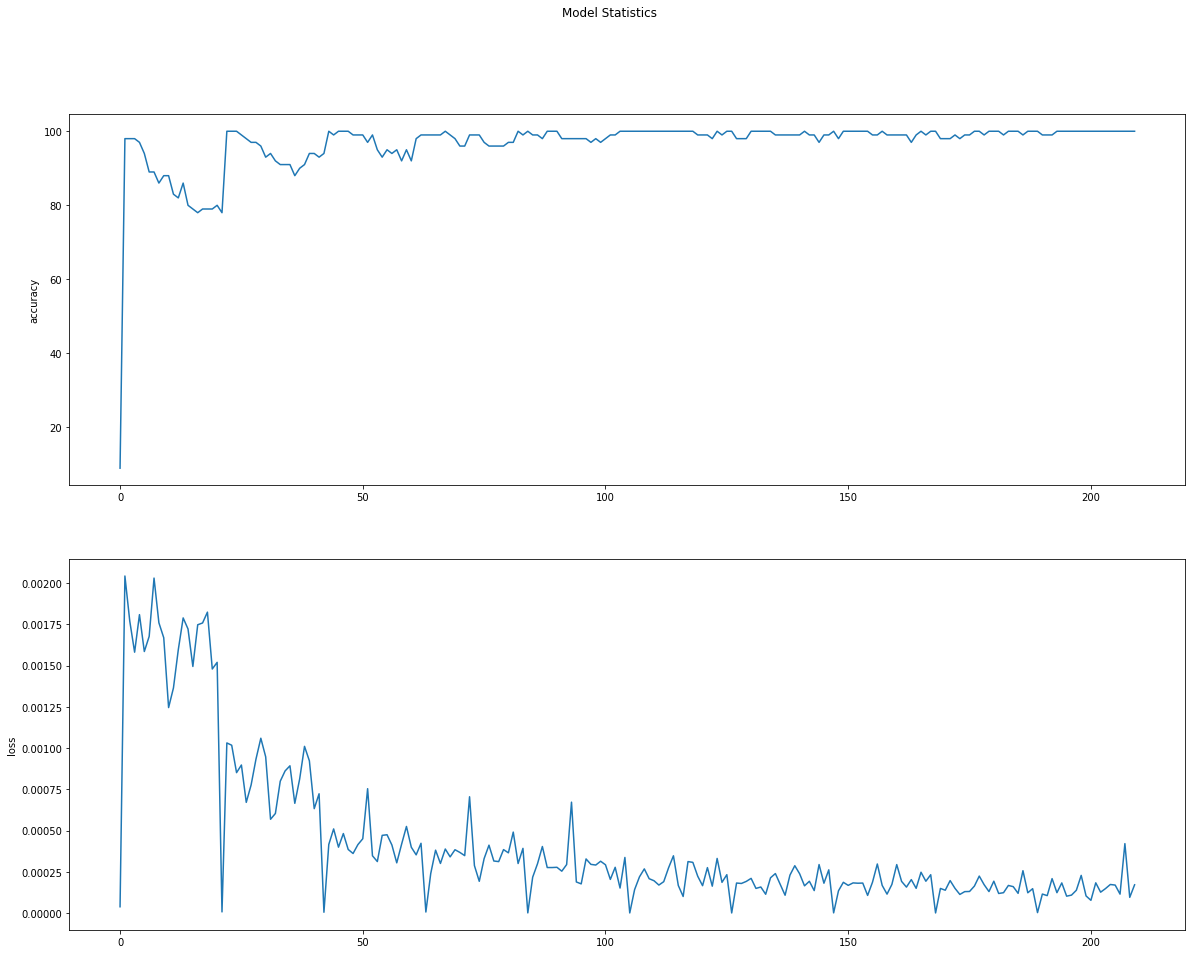

In [144]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

fig.suptitle('Model Statistics')

ax1.plot(accuracy)
ax1.set_ylabel('accuracy')

ax2.plot(losses)
ax2.set_ylabel('loss')

plt.show()

In [177]:
joy_dev = pd.read_csv('/content/joy-dev.tsv', error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')
anger_dev = pd.read_csv('/content/anger-dev.tsv', error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')
df_dev = pd.concat([joy_dev, anger_dev])
df_dev['emotion'].replace({'not-joy':'neutral', 'not-anger':'neutral'}, inplace=True)
df = shuffle(df_dev)
df

,emotion,text
0,neutral,"Elisa on tosin turhan kallis tällä hetkellä, m..."
1,neutral,Tai täytyy olla kanttia lopettaa edellinen suhde.
2,joy,” Kumartakaa Mahtavaa Ahteria !
3,neutral,OT määrittelee sinut koneeksi jossa on hieman ...
4,neutral,"Miehen ” kuolaan , koska osaan –katse ” näkyy ..."
...,...,...
295,neutral,Jotenkin sille kaikelle kiltteydelle ja mielly...
296,neutral,"No , mä olin tietty siinä ihan hoo-moilasena ."
297,joy,Minulla on onnellinen olo.
298,joy,"Vähän kallista, mutta hauskaa."


In [180]:
y_dev = []
for i in df['emotion']:
  if i == 'joy':
    y_dev.append([1,0,0])
  elif i == 'anger':
    y_dev.append([0,1,0])
  else:
    y_dev.append([0,0,1])
y_dev = torch.tensor(y_dev).float()

In [183]:
print('DEV  : ', score(model, df['text'], y_dev, dataset_size=len(df.index)))

DEV  :  74.66666666666667
